Module imports and configuration

In [1]:
import math
from typing import TypeAlias
import IPython
import matplotlib.cm as cm
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import polars as pl
import pyomo.environ as pyo
from pyomo.core import Model
from pyomo.core.expr.relational_expr import EqualityExpression

# Prevent truncation of tall tables
IPython.core.interactiveshell.InteractiveShell.ast_node_interactivity = "all"
pl.Config.set_tbl_rows(-1)  # "unlimited rows"

polars.config.Config

Units of measure

In [2]:
Id: TypeAlias = pl.String
MW: TypeAlias = pl.Float64
MWPerRad: TypeAlias = pl.Float64
USDPerMWh: TypeAlias = pl.Float64

Bus data

In [3]:
buses = pl.DataFrame(
    {
        "id": ["B1", "B2", "B3"],
        "load": [0.0, 0.0, 150.0],
    },
    schema={"id": Id, "load": MW},
)

In [4]:
buses

id,load
str,f64
"""B1""",0.0
"""B2""",0.0
"""B3""",150.0


Generator data

In [5]:
generators = pl.DataFrame(  # excludes "capacity", "cost"!
    {
        "id": ["G1", "G2", "G3"],
        "bus_id": ["B1", "B2", "B1"],
    },
    schema={"id": Id, "bus_id": Id},
)

Line data

In [6]:
lines = pl.DataFrame(
    {
        "from_bus_id": ["B1", "B1", "B2"],
        "to_bus_id": ["B2", "B3", "B3"],
        "susceptance": [1000, 1000, 1000],
        "capacity": [30.0, 100.0, 100.0],
    },
    schema={
        "from_bus_id": Id,
        "to_bus_id": Id,
        "susceptance": MWPerRad,
        "capacity": MW,
    },
)

Ensure edge pairs are consistely ordered to simplify look-ups

In [7]:
pairs = list(zip(lines[:, "from_bus_id"], lines[:, "to_bus_id"]))
lines = lines.with_columns(
    from_bus_id=pl.Series(min(p) for p in pairs),
    to_bus_id=pl.Series(max(p) for p in pairs),
)

Offer data

In [8]:
offers = pl.DataFrame(
    {
        "generator_id": ["G1", "G2", "G3", "G1", "G2", "G3", "G1", "G2", "G3"],
        "max_quantity": [200.0, 200.0, 200.0, 100.0, 100.0, 100.0, 200.0, 200.0, 200.0],
        "price": [10.00, 12.00, 14.00, 20.00, 22.00, 24.00, 15.00, 16.00, 17.00],
    },
    schema={"generator_id": Id, "max_quantity": MW, "price": USDPerMWh},
).sort(by=["generator_id", "price"])

Generate a unique identifier for each offer

In [9]:
for column in [
    pl.arange(0, pl.len()).over("generator_id").alias("tranche"),
    pl.format("{}/{}", pl.col("generator_id"), pl.col("tranche") + 1).alias("id"),
]:
    offers = offers.with_columns(column)

In [10]:
offers

generator_id,max_quantity,price,tranche,id
str,f64,f64,i64,str
"""G1""",200.0,10.0,0,"""G1/1"""
"""G1""",200.0,15.0,1,"""G1/2"""
"""G1""",100.0,20.0,2,"""G1/3"""
"""G2""",200.0,12.0,0,"""G2/1"""
"""G2""",200.0,16.0,1,"""G2/2"""
"""G2""",100.0,22.0,2,"""G2/3"""
"""G3""",200.0,14.0,0,"""G3/1"""
"""G3""",200.0,17.0,1,"""G3/2"""
"""G3""",100.0,24.0,2,"""G3/3"""


Index sets

In [11]:
Buses = range(buses.height)
Lines = range(lines.height)
Offers = range(offers.height)
Generators = range(generators.height)

PyOMO optimization model 

In [12]:
model = pyo.ConcreteModel()

Associated numeric parameters

In [13]:
model.loads = pyo.Param(
    Buses, initialize={b: buses[b, "load"] for b in Buses}, mutable=True
)
model.susceptances = pyo.Param(
    Lines, initialize={ell: lines[ell, "susceptance"] for ell in Lines}
)

Optimization decision variables and their bounds/limits

In [14]:
def supply_bounds(model: Model, o: int) -> tuple[float, float]:
    return (0.0, offers[o, "max_quantity"])


def flow_bounds(model: Model, ell: int) -> tuple[float, float]:
    capacity = lines[ell, "capacity"]
    return (-capacity, +capacity)


model.p = pyo.Var(Offers, bounds=supply_bounds)
model.f = pyo.Var(Lines, bounds=flow_bounds)
model.theta = pyo.Var(Buses, bounds=(-math.pi, +math.pi))

Associated a dual variable with each constraint

In [15]:
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

Optimization objective function

In [16]:
model.total_cost = pyo.Objective(
    expr=sum(offers[o, "price"] * model.p[o] for o in Offers),
    sense=pyo.minimize,
)

Incidence functions encoding bus-line and generator-bus-offer connectivity

In [17]:
def network_incidence(b: int, ell: int) -> int:
    if buses[b, "id"] == lines[ell, "from_bus_id"]:
        return -1
    if buses[b, "id"] == lines[ell, "to_bus_id"]:
        return +1
    else:
        return 0
    
def supply_incidence(b: int, g: int, o: int) -> bool:
    node_generator: bool = buses[b, "id"] == generators[g, "bus_id"]
    generator_offer: bool = generators[g, "id"] == offers[o, "generator_id"]
    return node_generator and generator_offer

Power balance constraint at each bus

In [18]:
def balance_rule(model: Model, b: int) -> EqualityExpression:
    return (
        sum(model.p[o] for g in Generators for o in Offers if supply_incidence(b, g, o))
        + sum(
            sign * model.f[ell]
            for ell in Lines
            if (sign := network_incidence(b, ell)) != 0
        )
        == model.loads[b]
    )

model.balance = pyo.Constraint(Buses, rule=balance_rule)

Power flow relationship at each line

In [19]:
def flow_rule(model: Model, ell: int) -> EqualityExpression:
    return (
        sum(
            sign * model.susceptances[b] * model.theta[b]
            for b in Buses
            if (sign := network_incidence(b, ell))
        )
        == model.f[ell]
    )

model.flow = pyo.Constraint(Lines, rule=flow_rule)

Fix the voltage angle at the reference bus

In [20]:
model.reference_angle = pyo.Constraint(expr=model.theta[0] == 0.0)

A function to optimize the model and return the objective value (total cost in $/h)

In [21]:
def optimize(model, tee=False) -> float:
    """Solve the optimization problem encoded in model and return the objective value."""
    solver = pyo.SolverFactory("highs")
    results = solver.solve(model, tee=tee)
    assert results.solver.termination_condition is pyo.TerminationCondition.optimal
    return pyo.value(model.total_cost)

Run the optimizer

In [22]:
optimize(model, tee=True)  # tee output to console

Running HiGHS 1.10.0 (git hash: fd86653): Copyright (c) 2025 HiGHS under MIT licence terms
LP   has 7 rows; 15 cols; 25 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+03]
  Cost   [1e+01, 2e+01]
  Bound  [3e+00, 2e+02]
  RHS    [2e+02, 2e+02]
Presolving model
5 rows, 6 cols, 13 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-7); columns 0(-15); elements 0(-25) - Reduced to empty
Solving the original LP from the solution after postsolve
Model status        : Optimal
Objective value     :  1.5600000000e+03
Relative P-D gap    :  0.0000000000e+00
HiGHS run time      :          0.00


1560.0

Exract optimal value of decision variables

In [23]:
quantity = [pyo.value(model.p[o]) for o in Offers]
flow = [pyo.value(model.f[ell]) for ell in Lines]
angles_deg = [pyo.value(model.theta[b]) * 180 / math.pi for b in Buses]

Extract the marginal prices: Derivatives of total system cost with respect to bus loads

In [24]:
marginal_prices = [model.dual[model.balance[b]] for b in Buses]

In [25]:
marginal_prices

[10.0, 12.0, 11.0]

Extend data tables with decision variables

In [26]:
offers = offers.with_columns(quantity=pl.Series(quantity))
lines = lines.with_columns(flow=pl.Series(flow))
buses = buses.with_columns(
    angle_deg=pl.Series(angles_deg), price=pl.Series(marginal_prices)
)

Extend data tables with post-processed quantities

In [27]:
lines = lines.with_columns(  # utilization of each line
    (pl.col("flow").abs() / pl.col("capacity")).alias("utilization")
)
offers = offers.join(  # bus_id for each offer
    generators[:, ("id", "bus_id")], left_on="generator_id", right_on="id", how="left"
)
offers = offers.with_columns(  # utilization of each offer
    (pl.col("quantity") / pl.col("max_quantity")).alias("utilization")
)

Verify marginal prices by direct evaluation

In [28]:
def marginal_price_estimate(model, b: int, delta_load: float = 1.0) -> float:
    # Restore nominal state before perturbation
    # (copy.deepcopy of pyomo models is not officially supported)
    f_unperturbed = optimize(model)
    load_original = model.loads[b]
    model.loads[b] += delta_load  # increment load at bus b
    f_perturbed = optimize(model)
    model.loads[b] = load_original  # restore model for next time
    return (f_perturbed - f_unperturbed) / delta_load


marginal_price_estimates = [marginal_price_estimate(model, b) for b in Buses]

In [29]:
marginal_price_estimates

[10.0, 12.0, 11.0]

In [30]:
for dual, direct in zip(marginal_prices, marginal_price_estimates):
    assert abs(dual - direct) < 1e-6

Helper functions for plotting: No need to look through these

In [31]:
def mapvalues(f, keys, *values) -> dict:
    return dict(zip(keys, map(f, *values)))


def hybrid_layout(
    G: nx.Graph,
    hub_scale: float = 1.0,
    satellite_scale: float = 1.0,
    k: float = 0.4,
    seed: int = 0,
) -> dict:
    """Produces a better outcome than either pure layout provided by networkx"""
    hubs = [n for n in G.nodes if G.degree(n) > 1]
    pos = nx.kamada_kawai_layout(G.subgraph(hubs), scale=hub_scale)
    for hub in hubs:
        satellites = {
            *G.successors(hub),
            *G.predecessors(hub),
        }.difference(hubs)
        pos.update(
            nx.circular_layout(
                G.subgraph(satellites),
                center=pos[hub],
                scale=satellite_scale,
            )
        )
        print(f"{hub} => {satellites}")
    assert len(pos) == G.number_of_nodes()
    return nx.spring_layout(G, pos=pos, fixed=hubs, seed=seed, k=k)


For node/vertex annotations

In [32]:
bus_price_labels = mapvalues(
    "{:}MW\n@ ${:.2f}/MWh".format, buses["id"], buses["load"], buses["price"]
)
offer_price_labels = mapvalues(
    "{:}MW\n@ ${:}/MWh".format, offers["id"], offers["max_quantity"], offers["price"]
)

load_norm = mc.Normalize(vmin=min(buses["load"]), vmax=max(buses["load"]))
load_cmap = cm.coolwarm  # Or plasma, inferno, magma, coolwarm, etc.
bus_colors = [load_cmap(load_norm(load)) for load in buses["load"]]
bus_colors = ["lightblue" for load in buses["load"]]

generator_cmap = plt.get_cmap(name="tab10", lut=generators.height)
generator_colors = {
    gid: mc.to_hex(generator_cmap(i)) for i, gid in enumerate(generators["id"])
}
offer_colors = [generator_colors[gid] for gid in offers["generator_id"]]

For edge/arc annotations

In [33]:
flow_labels = mapvalues(
    "{:.0f}MW/\n{:.0f}MW".format,
    zip(lines["from_bus_id"], lines["to_bus_id"]),
    lines["flow"],
    lines["capacity"],
)
supply_labels = mapvalues(
    "{:.0f}MW/\n{:.0f}MW".format,
    zip(offers["id"], offers["bus_id"]),
    offers["quantity"],
    offers["max_quantity"],
)

Network definition for plotting

In [34]:
network = nx.DiGraph()

network.add_nodes_from(buses["id"])
network.add_nodes_from(offers["id"])
node_labels = bus_price_labels | offer_price_labels

network.add_edges_from(zip(lines["from_bus_id"], lines["to_bus_id"]))
network.add_edges_from(zip(offers["id"], offers["bus_id"]))
edge_utilization = [*lines["utilization"], *offers["utilization"]]
edge_labels = flow_labels | supply_labels

Automatic network layout

In [35]:
scale = 50.0
pos: dict = hybrid_layout(
    network, hub_scale=scale, satellite_scale=scale, k=scale * 1.0
)

B1 => {'G3/1', 'G1/3', 'G1/1', 'G1/2', 'G3/3', 'G3/2'}
B2 => {'G2/1', 'G2/2', 'G2/3'}
B3 => set()


Network annotations

{'B1': Text(50.0, 2.3853402088278256e-06, 'B1'),
 'B2': Text(-24.999997480155983, -43.301271563064816, 'B2'),
 'B3': Text(-25.00000251984401, 43.30126917772461, 'B3')}

{'G1/1': Text(138.57842314642122, -4.123698185217245, 'G1/1'),
 'G1/2': Text(124.20481429098157, 48.647828042932254, 'G1/2'),
 'G1/3': Text(80.91053886859967, 82.48744199225763, 'G1/3'),
 'G2/1': Text(-98.23331580856171, -90.26997919631229, 'G2/1'),
 'G2/2': Text(-43.674526631626975, -126.11509867554366, 'G2/2'),
 'G2/3': Text(-108.75903497559842, -25.037422727976136, 'G2/3'),
 'G3/1': Text(25.376678960965027, 83.44001754089703, 'G3/1'),
 'G3/2': Text(65.75770477033961, -78.82136553077075, 'G3/2'),
 'G3/3': Text(117.99535048524878, -55.71653409540847, 'G3/3')}

{'B1': Text(50.0, -14.999997614659792, '0.0MW\n@ $10.00/MWh'),
 'B2': Text(-24.999997480155983, -58.301271563064816, '0.0MW\n@ $12.00/MWh'),
 'B3': Text(-25.00000251984401, 28.301269177724613, '150.0MW\n@ $11.00/MWh'),
 'G1/1': Text(138.57842314642122, -19.123698185217243, '200.0MW\n@ $10.0/MWh'),
 'G1/2': Text(124.20481429098157, 33.647828042932254, '200.0MW\n@ $15.0/MWh'),
 'G1/3': Text(80.91053886859967, 67.48744199225763, '100.0MW\n@ $20.0/MWh'),
 'G2/1': Text(-98.23331580856171, -105.26997919631229, '200.0MW\n@ $12.0/MWh'),
 'G2/2': Text(-43.674526631626975, -141.11509867554366, '200.0MW\n@ $16.0/MWh'),
 'G2/3': Text(-108.75903497559842, -40.037422727976136, '100.0MW\n@ $22.0/MWh'),
 'G3/1': Text(25.376678960965027, 68.44001754089703, '200.0MW\n@ $14.0/MWh'),
 'G3/2': Text(65.75770477033961, -93.82136553077075, '200.0MW\n@ $17.0/MWh'),
 'G3/3': Text(117.99535048524878, -70.71653409540846, '100.0MW\n@ $24.0/MWh')}

{('B1', 'B2'): Text(12.501344564633968, -21.64985903143193, '30MW/\n30MW'),
 ('B1', 'B3'): Text(12.501342044880118, 21.649860224230167, '90MW/\n100MW'),
 ('B2', 'B3'): Text(-25.00000000012406, 0.0021315245551249973, '60MW/\n100MW'),
 ('G1/1', 'B1'): Text(94.29058730249727, -2.0619119459606168, '120MW/\n200MW'),
 ('G1/2', 'B1'): Text(87.10254429154463, 24.324005125517004, '0MW/\n200MW'),
 ('G1/3', 'B1'): Text(65.45525067912462, 41.24367213899578, '0MW/\n100MW'),
 ('G2/1', 'B2'): Text(-61.615585332501624, -66.78493828623776, '30MW/\n200MW'),
 ('G2/2', 'B2'): Text(-34.33725110762083, -84.70813656824386, '0MW/\n200MW'),
 ('G2/3', 'B2'): Text(-66.88078005314284, -34.16907156554373, '0MW/\n100MW'),
 ('G3/1', 'B1'): Text(37.688437733727994, 41.719677016467045, '0MW/\n200MW'),
 ('G3/2', 'B1'): Text(57.87859504283125, -39.409394324639266, '0MW/\n200MW'),
 ('G3/3', 'B1'): Text(83.99782567259882, -27.85838911989117, '0MW/\n100MW')}

(np.float64(-134.7294680784105),
 np.float64(164.54885624923327),
 np.float64(-148.11838587826992),
 np.float64(105.4433047436233))

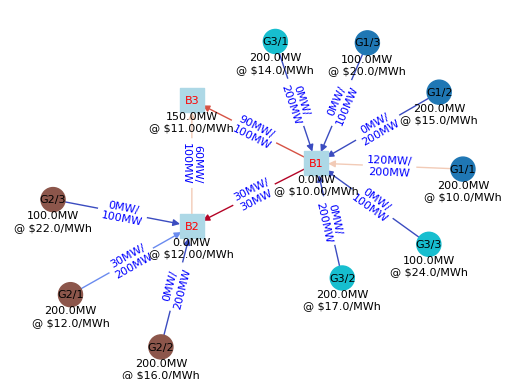

In [36]:
font_size = 8
nx.draw_networkx_nodes(
    network, pos, nodelist=buses["id"], node_color=bus_colors, node_shape="s"
)
nx.draw_networkx_nodes(
    network, pos, nodelist=offers["id"], node_color=offer_colors, node_shape="o"
)
nx.draw_networkx_labels(
    network,
    pos,
    labels={id: id for id in buses["id"]},
    font_size=font_size,
    font_color="red",
)
nx.draw_networkx_labels(
    network,
    pos,
    labels={id: id for id in offers["id"]},
    font_size=font_size,
    font_color="black",
)
nx.draw_networkx_labels(
    network,
    {id: xy + [0, -0.3 * scale] for id, xy in pos.items()},
    labels=node_labels,
    font_size=font_size,
)
nx.draw_networkx_edges(
    network,
    pos,
    edge_color=edge_utilization,
    edge_cmap=cm.coolwarm,
    edge_vmin=0.0,
    edge_vmax=1.0,
)
nx.draw_networkx_edge_labels(
    network,
    pos,
    edge_labels=edge_labels,
    font_size=font_size,
    font_color="blue",
)

plt.axis("off")
plt.savefig("network.png", dpi=300)
plt.show(block=False)

Path analysis

In [37]:
path_rows: list[dict] = []
path_edge_rows: list[dict] = []
undirected_network = network.to_undirected()

for source in buses[:, "id"]:
    for target in buses[:, "id"]:
        if source == target:
            continue
        node_sequences = nx.all_simple_paths(
            undirected_network, source=source, target=target
        )
        edge_sequences = list(map(nx.utils.pairwise, node_sequences))
        for path_count, sequence in enumerate(edge_sequences, start=1):
            path_id = f"{source}-{target}/{path_count}"
            edge_rows: list[dict] = []
            path_resistance = 0.0
            for from_node_id, to_node_id in sequence:
                orientation = 1 if from_node_id < to_node_id else -1
                if orientation == -1:
                    from_node_id, to_node_id = to_node_id, from_node_id
                susceptance, utilization = (
                    lines.filter(
                        (pl.col("from_bus_id") == from_node_id)
                        & (pl.col("to_bus_id") == to_node_id)
                    )
                    .select(["susceptance", "utilization"])
                    .row(0)
                )
                path_resistance += 1 / susceptance
                path_edge_rows.append(
                    dict(
                        from_node_id=from_node_id,
                        to_node_id=to_node_id,
                        orientation=orientation,
                        is_congested=0.99 < utilization,
                        path_id=path_id,
                        # source=source,
                        # target=target,
                    )
                )
            path_rows.append(
                dict(
                    path_id=path_id,
                    source=source,
                    target=target,
                    susceptance=1 / path_resistance,
                )
            )

paths = pl.DataFrame(path_rows)
path_edges = pl.DataFrame(path_edge_rows)

group_keys = ["source", "target"]
grouped = paths.group_by(group_keys).agg(
    pl.col("susceptance").sum().alias("total_susceptance")
)
paths = paths.join(grouped, on=group_keys).with_columns(
    (pl.col("susceptance") / pl.col("total_susceptance")).alias("relative_susceptance")
)

path_edges = path_edges.join(
    paths[:, ("path_id", "source", "target", "relative_susceptance")], on=["path_id"]
)

congested_path_edges = path_edges.filter(pl.col("is_congested"))

input_nodes = set(offers[:, "bus_id"])

path_summary = paths.group_by(["target"]).agg(pl.all()).sort(["target"])
congestion_summary = (
    congested_path_edges.group_by(["from_node_id", "to_node_id", "target"])
    .agg(pl.all())
    .sort(["target"])
)

Constraints implied by congestion

In [38]:
for target, coeffs, sources in congestion_summary.select(
    "target", "relative_susceptance", "source"
).iter_rows():
    terms = [
        f"{c:.2f}*PTotal[{s}]" for c, s in zip(coeffs, sources) if s in input_nodes
    ]
    print(f"@ {target}: {' + '.join(terms)} == 0")

@ B1: 0.67*PTotal[B2] == 0
@ B2: 0.67*PTotal[B1] == 0
@ B3: 0.33*PTotal[B1] + 0.33*PTotal[B2] == 0


Constraints implied unit increment

In [39]:
for target, sources in path_summary.select("target", "source").iter_rows():
    terms = [f"PTotal[{s}]" for s in set(sources) if s in input_nodes]
    print(f"@ {target}: {' + '.join(terms)} == 1")

@ B1: PTotal[B2] == 1
@ B2: PTotal[B1] == 1
@ B3: PTotal[B1] + PTotal[B2] == 1
